# Train a neural network.

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Set parameters

In [18]:
# file with training input and output data: format is x,y
input_file = 'training.csv'

# names of input/output columns
inputs = ['mu', 'angle', 'threshold']
outputs = ['speed']#['low_speed', 'high_speed']

# these set the input/output dimensions of the network
input_size = len(inputs)
output_size = len(outputs)

Read data

In [19]:
data = pd.read_csv(input_file)
data.columns = inputs + outputs

x = np.array(data[inputs])
y = np.array(data[outputs])

Normalizing preprocessing layer from training data

In [5]:
normalizer = keras.layers.experimental.preprocessing.Normalization()
normalizer.adapt(x)

Penalize overpredictions more than underpredictions

In [12]:
def asymmetric_mse(y_true, y_pred):
  # definition of MSE from tensorflow2/keras
  y_true = keras.backend.cast(y_true, y_pred.dtype)
  standard_mse = keras.backend.mean(keras.backend.square(y_pred - y_true), axis=-1)
  standard_mse = keras.backend.cast(standard_mse, 'float32')
  # penalize overpredictions more
  geq = keras.backend.greater(y_pred-y_true, 0) # true/false, are there overpredictions?
  geq_num = keras.backend.cast(geq, 'float32') # change bool to float
  geq_sum = keras.backend.sum(geq_num) # > 0 if there are overpredictions
  geq_scale = keras.backend.switch(geq_sum>0,5.0,1.0) # if there are overpredictions, scale up mse
  return geq_scale * standard_mse

Base model

In [36]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(4, activation='linear',input_dim=input_size,kernel_regularizer=keras.regularizers.l2(0.0000001)))
model.add(keras.layers.Dense(10,activation='relu'))
model.add(keras.layers.Dense(10,activation='relu'))
model.add(keras.layers.Dense(output_size,activation='softplus'))
model.compile(loss=asymmetric_mse,optimizer='adam')

Compile model

In [37]:
input_shape = x.shape[1:]
full_model_input = keras.Input(shape=input_shape)
normalized_input = normalizer(full_model_input)
full_model_output = model(normalized_input)
full_model = keras.Model(full_model_input, full_model_output)
full_model.compile(loss=asymmetric_mse,optimizer='adam',metrics=['mse'])

Split data

In [38]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, shuffle= True)

Train model

In [43]:
model_output = full_model.fit(x_train,y_train,epochs=100,batch_size=10,verbose=0,validation_data=(x_val,y_val)) # check validation

View output

<Figure size 432x288 with 0 Axes>

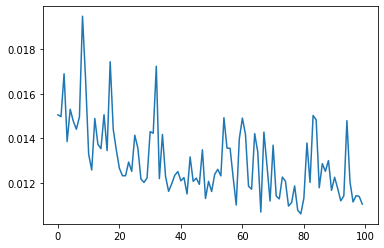

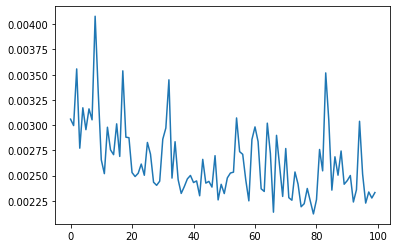

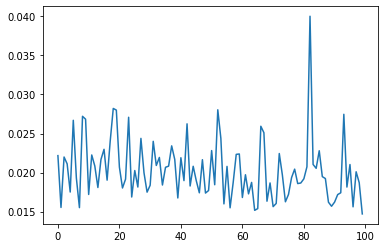

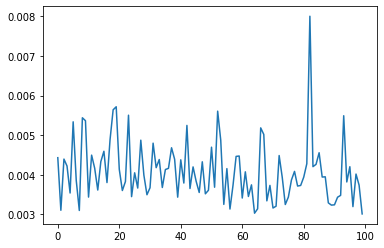

<Figure size 432x288 with 0 Axes>

In [44]:
#plt.yscale('log')
plt.plot(model_output.history['loss'])
plt.figure()
#plt.yscale('log')
plt.plot(model_output.history['mse'])
plt.figure()
#plt.yscale('log')
plt.plot(model_output.history['val_loss'])
plt.figure()
#plt.yscale('log')
plt.plot(model_output.history['val_mse'])
plt.figure()

Save model

In [45]:
full_model.save("1_speed_network.h5")